In [112]:
import scipy.integrate
import numpy
import matplotlib.pyplot
import os
import json
import scipy.interpolate
import cModel

def dfdy(t,y,system):
    dfdy=system.M.dot(y)+system.u(t)
    return dfdy

def jacobi(t,y,system):
    return system.M

#SE post calculation
def dfdyS(t,S,system):
    #unwrap S to NxM where M is number of parameters
    mS=numpy.reshape(S,(system.n,system.m))
    mOut=system.M.dot(mS)+system.fS(t)
    return numpy.ravel(mOut)

def jacobiSE(t,S,system):
    N=system.n*(system.m)
    fJ=numpy.zeros((N,N))
    #print('fJ shape {}'.format(fJ.shape))
    for i in range(system.m):
        fJ[i*system.n:(i+1)*system.n,i*system.n:(i+1)*system.n]=system.M
    return fJ

#SE simultaeneous calculation
def dfdySFull(t,S,system):
    #unwrap S to NxM where M is number of parameters
    mS=numpy.reshape(S,(system.n,system.m+1))
    #system.fS(y,t) is NxM matrix where M are parameters
    y=mS[:,0]
    mOut=system.M.dot(mS)+system.fSY(y,t)
    return numpy.ravel(mOut)

def jacobiSEFull(t,S,system):
    N=system.n*(system.m+1)
    fJ=numpy.zeros((N,N))
    #print('fJ shape {}'.format(fJ.shape))
    for i in range(system.m+1):
        fJ[i*system.n:(i+1)*system.n,i*system.n:(i+1)*system.n]=system.M
    return fJ



In [153]:
sys=cModel.model()
fh=os.path.expanduser('~')
#sys.parse(os.path.join(fh,'software','src','Integra','models','cDiazepam.json'))
sys.parse(os.path.join(fh,'software','src','Integra','models','cDiazepam.json'))
#print(sys.u(10)[sys.lut['venous']])
sys.inspect()         
nt=201
tmax=4*3600
t = numpy.linspace(0,tmax, nt)
#first column is the solution y
#initial condition
y0=numpy.zeros(sys.n)
    
doSequential=0
doSimultaneous=0
doIVP=0
doIVPSimultaneous=1

if doSequential:
#sequential SE (first true solution, then parameter derivatives)
    y0=numpy.zeros(sys.n)
    sol = scipy.integrate.odeint(dfdy, y0=y0, t=t, args=(sys,),Dfun=jacobi,tfirst=True)
    print('shape (y) {}'.format(sol.shape))
    
    #solLSODA = scipy.integrate.LSODA(dfdy,y0,0,tbound=4*3600,min_step=10,max_step=1000,jac=jacobi)
    #sol=solLSODA.
    sys.setY(t,sol)
    S0=numpy.zeros((sys.n,sys.m))
    S0=S0.ravel()
    #print('lut {}'.format(sys.lut))
    #print('lutSE {}'.format(sys.lutSE))
    #fJ=sys.fSS[sys.lutSE['brainPC']]
    #print('X shape {}\n {}'.format(fJ.shape,fJ))
    solSE=scipy.integrate.odeint(dfdyS, S0, t, args=(sys,),Dfun=jacobiSE,tfirst=True)
    s1=numpy.reshape(solSE,(len(t),sys.n,sys.m))
    print('Done sequential SE')
    

if doSimultaneous:
#simultaneous SE
    S1=numpy.zeros((sys.n,sys.m+1))
    #set initial condition
    S1[:,0]=y0
    S1=S1.ravel()
    solSE1=scipy.integrate.odeint(dfdySFull, S1, t, args=(sys,),Dfun=jacobiSEFull,tfirst=True)
    sFull=numpy.reshape(solSE1,(len(t),sys.n,sys.m+1))
    s1=sFull[:,:,1:]
    sol=sFull[:,:,0]
    print('Done simultaneous SE')

if doIVP:
    solIVP=scipy.integrate.solve_ivp(dfdy,[0, tmax],y0, args=(sys,), jac=jacobi,
                                  method='LSODA', atol=1e-4, rtol=1e-8)
    #y is n x nt (odeint nt x n)
    sol=numpy.transpose(solIVP.y)
    t=solIVP.t
    print('shape (y) {}'.format(sol.shape))
    sys.setY(t,sol)
    solIVPSE=scipy.integrate.solve_ivp(dfdyS,[0, tmax],S0, args=(sys,), jac=jacobiSE,
                                  method='LSODA', atol=1e-4, rtol=1e-8)
    sraw=numpy.reshape(numpy.transpose(solIVPSE.y),(len(solIVPSE.t),sys.n,sys.m))
    #interpolate on t
    s1=numpy.zeros((len(t),sys.n,sys.m))
    for i in range(sys.n):
        for j in range(sys.m):
            tck = scipy.interpolate.splrep(solIVPSE.t, sraw[:,i,j], s=0)
            s1[:,i,j]=scipy.interpolate.splev(t, tck, der=0)
        
if doIVPSimultaneous:
    S1=numpy.zeros((sys.n,sys.m+1))
    #set initial condition
    S1[:,0]=y0
    S1=S1.ravel()
    solIVP1=scipy.integrate.solve_ivp(dfdySFull,[0, tmax],S1, args=(sys,), jac=jacobiSEFull,
                                  method='LSODA', atol=10, rtol=1e-2)
    t=solIVP1.t
    sFull=numpy.reshape(numpy.transpose(solIVP1.y),(len(t),sys.n,sys.m+1))
    s1=sFull[:,:,1:]
    sol=sFull[:,:,0]
    print('Done simultaneous LSODA SE')
    
    
#calculate uncertainty
#s1 is nt x nvar x npar

se=sys.calculateUncertainty(sol,s1)


Compartments
adipose/0:
	targets
		adipose[0,0]: -0.00018398268398268396
		arterial[0,13]: 0.0042499999999999994
brain/1:
	targets
		brain[1,1]: -0.004924242424242425
		arterial[1,13]: 0.010833333333333335
heart/2:
	targets
		heart[2,2]: -0.016279069767441864
		arterial[2,13]: 0.07
kidney/3:
	targets
		kidney[3,3]: -0.02661858974358974
		arterial[3,13]: 0.13841666666666666
liver/4:
	targets
		liver[4,4]: -0.01477905427905428
		splanchnic[4,5]: 0.007135306553911206
		stomach[4,6]: 0.0006397306397306397
		arterial[4,13]: 0.005378787878787879
splanchnic/5:
	targets
		splanchnic[5,5]: -0.0052325581395348845
		arterial[5,13]: 0.022500000000000003
stomach/6:
	targets
		stomach[6,6]: -0.006397306397306396
		arterial[6,13]: 0.028787878787878782
muscle/7:
	targets
		muscle[7,7]: -0.0009027777777777777
		arterial[7,13]: 0.0021666666666666666
skin/8:
	targets
		skin[8,8]: -0.0008442732115677322
		arterial[8,13]: 0.0027016742770167427
testes/9:
	targets
		testes[9,9]: -0.002695035460992907
		arter

(5180, 16, 3)


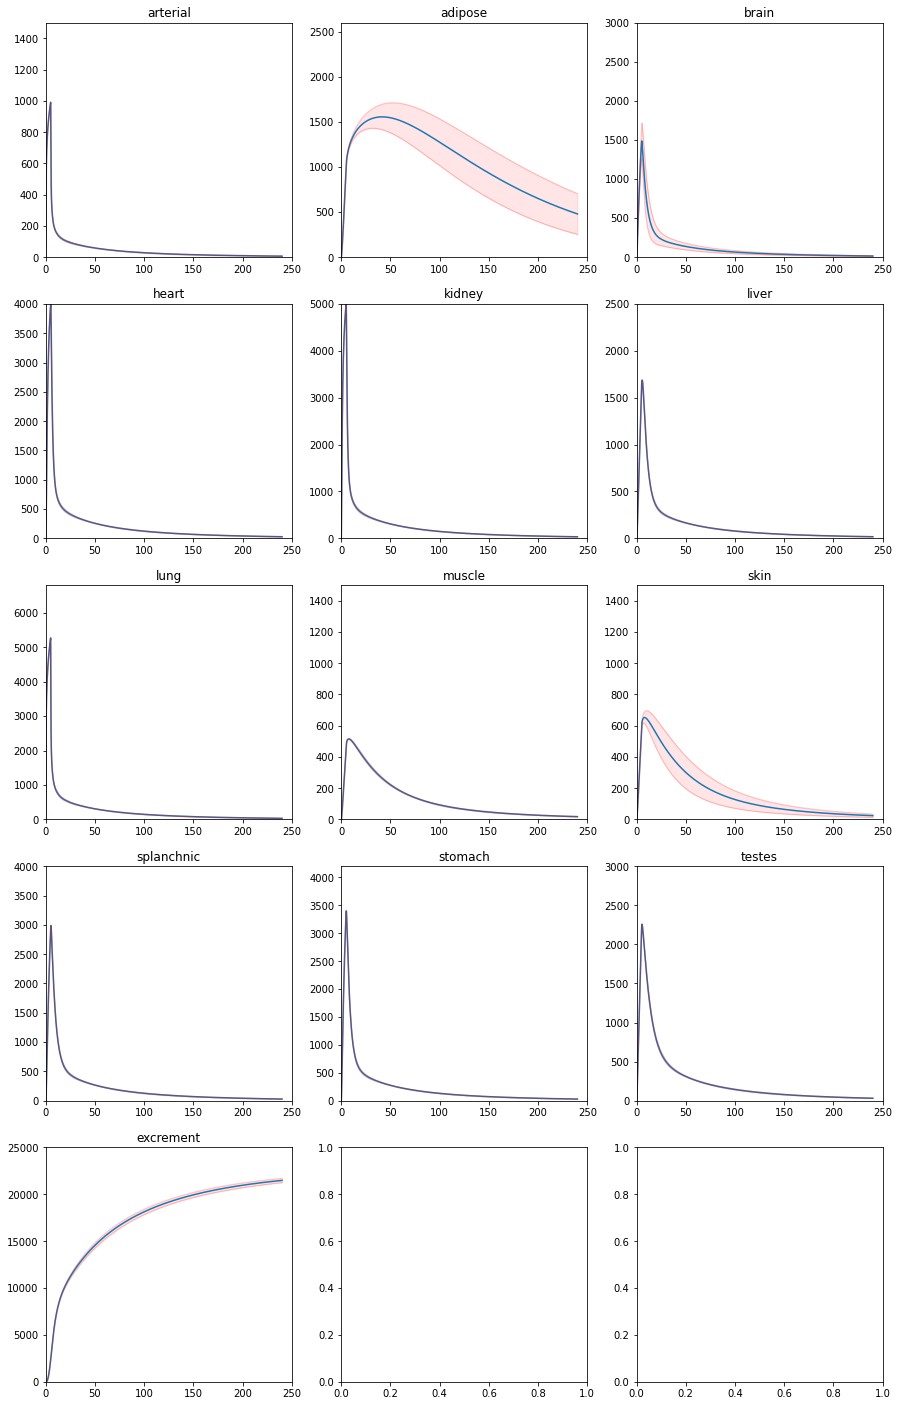

In [154]:
#copy output of Thompson et al
print(s1.shape)
fig, axs = matplotlib.pyplot.subplots(5, 3,figsize=(15,25))
name=['arterial','adipose','brain','heart','kidney','liver','lung','muscle','skin',
      'splanchnic','stomach','testes','excrement']
#diazepam
max=[1.5,2.6,3,4,5,2.5,6.8,1.5,1.5,4,4.2,3,25]
#cotinine
#max=[9]*13
#max[12]=90

max=[1000*x for x in max]
for i in range(len(name)):
    row=i//3
    col=i%3
    fy=sol[:,sys.lut[name[i]]]
    fe=se[:,sys.lut[name[i]]]
    ax=axs[row,col]
    ax.plot(t/60,fy)
    ax.fill_between(t/60, fy-fe, fy + fe, color='red',alpha=0.1)
    ax.plot(t/60,fy-fe,color='red',linewidth=1,alpha=0.2)
    ax.plot(t/60,fy+fe,color='red',linewidth=1,alpha=0.2)
    axs[row,col].set_title(name[i])
    axs[row,col].set_ylim([0,max[i]])
    axs[row,col].set_xlim([0,250])


In [131]:
5e2/30/13.6


1.2254901960784315

In [58]:
fse=s1[:,:,0]
numpy.argwhere(numpy.isnan(fse))
fse[:,0]

array([0.00000000e+000, 9.46314230e+003, 6.45365940e+003, 5.67275261e+003,
       6.26418952e-007, 1.79899429e-007, 1.79899429e-007, 3.22904947e-009,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 5.56433140e+115, 0.00000000e+000, 0.00000000e+000,
                   inf, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 4.49748572e-008, 4.49748572e-008,
       7.19597716e-007, 4.49748572e-008, 4.49748572e-008, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [18]:
M=numpy.ones((3,2,2))
M[0,0,1]=2
M[1,1,0]=3
M[2,1,1]=5
v=numpy.ones(2)
q=M.dot(v)
q1=q.ravel()
q2=numpy.reshape(q1,q.shape)
print(q)
print(q2)

[[3. 2.]
 [2. 4.]
 [2. 6.]]
[[3. 2.]
 [2. 4.]
 [2. 6.]]
